In [ ]:
# from google.colab import drive
# import pandas as pd
# drive.mount('/content/gdrive') 

# 套件

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn import preprocessing
from collections import Counter
import imblearn
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction import DictVectorizer

import os
import joblib
import numpy as np
from sklearn.datasets import load_iris

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# 一些函式

In [ ]:
def specificity_score(y_true, y_predict):
    from sklearn.metrics import confusion_matrix
    conf = confusion_matrix(y_true=y_true, y_pred=y_predict)
    return conf[0,0]/(conf[0,0]+conf[0, 1])

def opt_score(y_true, y_predict):
    
    target1_pro = 0.919271
    target0_pro = 1 - target1_pro
    
    opt_score = specificity_score(y_true, y_predict)*target1_pro*0.03 - (1-recall_score(y_true, y_predict))*target0_pro
    return (opt_score+0.1)*5

def opt_score2(y_true, y_predict, x_train):
    import numpy as np
    y_predict = np.array(y_predict)
    pos_index = (y_predict > 0.5).nonzero()
    neg_index = (y_predict < 0.5).nonzero()
    true_index = (y_true == 1).nonzero()
    false_index = (y_true == 0).nonzero()
    
    # specificity 
    s_index = np.intersect1d(neg_index, false_index)
    s_loss = x_train[s_index,3].sum() # annuty
    # (1-recall)
    invr_index = np.intersect1d(neg_index, true_index)
    invr_loss = x_train[invr_index, 2].sum() # credict
    
    return (s_loss - invr_loss)/x_train.shape[0]
  
def plot_confusion_matrix(y_test,result):
    plt_title = 'Stock Breach'

    from sklearn.metrics import confusion_matrix
    confmat = confusion_matrix(y_true=y_test, y_pred=result)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xticks([0, 1], [0, 1])
    plt.yticks([0, 1], [0, 1])
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(plt_title)
    plt.tight_layout()
    plt.savefig('under_sampling_confusion_matrix.png', transparent = True)
    plt.show()


    acc = accuracy_score(y_test, result)
    f1 = f1_score(y_test, result)
    precision = precision_score(y_test, result)
    recall = recall_score(y_test, result)
    spe = specificity_score(y_test, result)
    opt = opt_score(y_test, result)
    print('accuracy =', acc)
    print('f1_score =', f1)
    print('precision =', precision)
    print('recall =', recall)
    print('specificity =', spe)
    print('opt_score =', opt)
    print()


# 下載檔案

In [ ]:
!gdown --id '1OgPawokX8BE-laTOxmgKAzz9JYO45dRa' --output train.csv
!gdown --id '1wCBf0QTnEme4yvrVQez75_CaWtapDbSe' --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OgPawokX8BE-laTOxmgKAzz9JYO45dRa
To: /content/train.csv
1.77GB [00:13, 130MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wCBf0QTnEme4yvrVQez75_CaWtapDbSe
To: /content/test.csv
705MB [00:16, 42.7MB/s]


In [ ]:
import numpy as np  
import pandas as pd
df1 = pd.read_csv("/content/train.csv")
df2 = pd.read_csv("/content/test.csv")

df1 = df1.drop(columns='Unnamed: 0')
df2 = df2.drop(columns='Unnamed: 0')

In [ ]:
df1.head()

,BS_CODE,PRICE,STOCKS,ROI,AGE_LEVEL,OPEN_ACCT_YEAR,SOURCE_CODE,BREACH_IND,INVESTMENT_TXN_CODE,BUY_COUNT,SELL_COUNT,NONTXN_COUNT,OPEN_PRICE,MAX_PRICE,MIN_PRICE,CLOSE_PRICE,VOLUME,AMONT,ALPHA,BETA_21D,BETA_65D,BETA_250D,MA_5D,MA_20D,MA_5D_Gap,MA_20D_Gap,MA_5D_RATE,MA_20D_RATE,COST,MARKET_TYPE_CODE_H,MARKET_TYPE_CODE_O,COMMISION_TYPE_CODE_0,COMMISION_TYPE_CODE_1,COMMISION_TYPE_CODE_2,COMMISION_TYPE_CODE_9,COMMISION_TYPE_CODE_A,CAPITAL_TYPE_H,CAPITAL_TYPE_M,CAPITAL_TYPE_S,INDUSTRY_其他,...,INDUSTRY_存託憑證,INDUSTRY_建材營建,INDUSTRY_文化創意,INDUSTRY_橡膠工業,INDUSTRY_水泥工業,INDUSTRY_汽車工業,INDUSTRY_油電燃氣,INDUSTRY_玻璃陶瓷,INDUSTRY_生技醫療,INDUSTRY_紡織纖維,INDUSTRY_航運業,INDUSTRY_觀光事業,INDUSTRY_貿易百貨,INDUSTRY_農業科技,INDUSTRY_造紙工業,INDUSTRY_金融保險,INDUSTRY_鋼鐵工業,INDUSTRY_電器電纜,INDUSTRY_電子–光電,INDUSTRY_電子–其他電子,INDUSTRY_電子–半導體,INDUSTRY_電子–資訊服務,INDUSTRY_電子–通信網路,INDUSTRY_電子–電子通路,INDUSTRY_電子–電子零組件,INDUSTRY_電子–電腦及週邊設備,INDUSTRY_電子商務,INDUSTRY_電機機械,INDUSTRY_食品工業,NUM,BETA_21D_CUMSUM_MEAN,BETA_21D_CUMSUM_GAP,BETA_65D_CUMSUM_MEAN,BETA_65D_CUMSUM_GAP,BETA_250D_CUMSUM_MEAN,BETA_250D_CUMSUM_GAP,COST_CUMSUM_MEAN,COST_CUMSUM_RATE,ALPHA_CUMSUM_MEAN,ALPHA_CUMSUM_GAP
0,1,8.45,1000.0,0.00,4.0,2008.0,1.0,0.0,4.0,450.0,463.0,2.0,8.44,8.53,8.21,8.46,58060.0,485999.0,0.1619,-2.6675,-3.0508,-3.9323,8.460,8.46,0.000,0.0,1.000000,1.0,8450.0,1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,2.667500,0.000000,3.050800,0.000000,3.932300,1.0,8450.000000,0.00000,-0.16190
1,0,32.65,1000.0,2.11,4.0,2008.0,1.0,0.0,4.0,450.0,463.0,2.0,32.65,33.00,31.60,32.60,103.0,3328.0,0.0082,0.4594,0.9848,0.6627,32.020,32.60,-0.580,0.0,0.982209,1.0,32650.0,1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-2.667500,-3.126900,-3.050800,-4.035600,-3.932300,-4.595000,8450.0,3.863905,0.16190,0.15370
2,1,7.98,1000.0,0.00,4.0,2008.0,1.0,0.0,4.0,450.0,463.0,2.0,7.96,8.04,7.75,8.00,72234.0,570689.0,0.1629,-2.2013,-2.7284,-3.8907,8.214,8.00,0.214,0.0,1.026750,1.0,7980.0,1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,-1.104050,1.097250,-1.033000,1.695400,-1.634800,2.255900,20550.0,0.388321,0.08505,-0.07785
3,1,15.85,1000.0,0.00,4.0,2008.0,1.0,0.0,4.0,450.0,463.0,2.0,15.90,15.90,15.35,15.75,87.0,1356.0,-0.0416,0.7317,0.2993,0.4642,15.970,15.75,0.220,0.0,1.013968,1.0,15850.0,0,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,-1.469800,-2.201500,-1.598133,-1.897433,-2.386767,-2.850967,16360.0,0.968826,0.11100,0.15260
4,0,15.75,1000.0,-3.37,4.0,2008.0,1.0,0.0,4.0,450.0,463.0,2.0,15.75,15.80,15.30,15.75,43.0,669.0,-0.0366,0.7038,0.2837,0.4624,15.950,15.75,0.200,0.0,1.012698,1.0,15750.0,0,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,-0.919425,-1.623225,-1.123775,-1.407475,-1.674025,-2.136425,16232.5,0.970276,0.07285,0.10945


# 特徵選擇

In [ ]:
#feature selection
drop_feat = [8,9,10,11,36,37,38,71]+ list(range(40,50)) +[51,59,60,61,65,66] + list(range(71,82))

df1 = df1.drop(df1.columns[drop_feat],axis=1)
df2 = df2.drop(df2.columns[drop_feat],axis=1)

col_name = df1.columns

print('The shape of df1 is:', df1.shape)
print('The shape of df2 is:', df2.shape)

The shape of df1 is: (3472522, 48)
The shape of df2 is: (1439297, 48)


In [ ]:
df1.head()

,BS_CODE,PRICE,STOCKS,ROI,AGE_LEVEL,OPEN_ACCT_YEAR,SOURCE_CODE,BREACH_IND,OPEN_PRICE,MAX_PRICE,MIN_PRICE,CLOSE_PRICE,VOLUME,AMONT,ALPHA,BETA_21D,BETA_65D,BETA_250D,MA_5D,MA_20D,MA_5D_Gap,MA_20D_Gap,MA_5D_RATE,MA_20D_RATE,COST,MARKET_TYPE_CODE_H,MARKET_TYPE_CODE_O,COMMISION_TYPE_CODE_0,COMMISION_TYPE_CODE_1,COMMISION_TYPE_CODE_2,COMMISION_TYPE_CODE_9,COMMISION_TYPE_CODE_A,INDUSTRY_其他,INDUSTRY_生技醫療,INDUSTRY_航運業,INDUSTRY_觀光事業,INDUSTRY_貿易百貨,INDUSTRY_農業科技,INDUSTRY_造紙工業,INDUSTRY_金融保險,INDUSTRY_鋼鐵工業,INDUSTRY_電子–半導體,INDUSTRY_電子–資訊服務,INDUSTRY_電子–通信網路,INDUSTRY_電子–電腦及週邊設備,INDUSTRY_電子商務,INDUSTRY_電機機械,INDUSTRY_食品工業
0,1,8.45,1000.0,0.00,4.0,2008.0,1.0,0.0,8.44,8.53,8.21,8.46,58060.0,485999.0,0.1619,-2.6675,-3.0508,-3.9323,8.460,8.46,0.000,0.0,1.000000,1.0,8450.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,32.65,1000.0,2.11,4.0,2008.0,1.0,0.0,32.65,33.00,31.60,32.60,103.0,3328.0,0.0082,0.4594,0.9848,0.6627,32.020,32.60,-0.580,0.0,0.982209,1.0,32650.0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,7.98,1000.0,0.00,4.0,2008.0,1.0,0.0,7.96,8.04,7.75,8.00,72234.0,570689.0,0.1629,-2.2013,-2.7284,-3.8907,8.214,8.00,0.214,0.0,1.026750,1.0,7980.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,15.85,1000.0,0.00,4.0,2008.0,1.0,0.0,15.90,15.90,15.35,15.75,87.0,1356.0,-0.0416,0.7317,0.2993,0.4642,15.970,15.75,0.220,0.0,1.013968,1.0,15850.0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,15.75,1000.0,-3.37,4.0,2008.0,1.0,0.0,15.75,15.80,15.30,15.75,43.0,669.0,-0.0366,0.7038,0.2837,0.4624,15.950,15.75,0.200,0.0,1.012698,1.0,15750.0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 資料處理

*   train test split
*   undersampling



In [ ]:
def data_process_mix(train,test): 
    #seperate x y
    x_1 = train.drop('BREACH_IND', axis = 1)
    # x_1 = preprocessing.scale(x_1) #normalize
    y_1 = train['BREACH_IND']

    #seperate x y
    x_2 = test.drop('BREACH_IND', axis = 1)
    # x_2 = preprocessing.scale(x_2) #normalize
    y_2 = test['BREACH_IND']

    #Undersampling of data1
    print("Before undersampling: ", Counter(y_1))
    undersample = RandomUnderSampler(sampling_strategy = 0.0001)
    x_under_train, y_under_train = undersample.fit_resample(x_1, y_1)
    print("After undersampling: ", Counter(y_under_train))

    #Undersampling of data2
    print("Before undersampling: ", Counter(y_2))
    undersample = RandomUnderSampler(sampling_strategy = 0.0001)
    x_under_test, y_under_test = undersample.fit_resample(x_2, y_2)
    print("After undersampling: ", Counter(y_under_test))
    print("After undersampling: ", x_under_test.size)

    #combine two dataset
    x = np.append(x_under_train,x_under_test,axis=0)
    y = np.append(y_under_train,y_under_test,axis=0)

    #split train test
    x_train, x_test, y_train, y_test\
    = train_test_split(x, y, test_size=0.2, random_state=1) 

    #Validation
    x_train, x_val, y_train, y_val\
    = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

    return x_train,y_train,x_val,y_val,x_test,y_test

def data_process_by_year(train,test):
  #make train data
  x_train = train.drop('BREACH_IND', axis = 1)
  x_train = preprocessing.scale(x_train)
  y_train = train['BREACH_IND']

  #make test data
  x_test = test.drop('BREACH_IND',axis=1)
  x_test = preprocessing.scale(x_test)
  y_test = test['BREACH_IND']

  #減少training sample=
  undersample = RandomUnderSampler(sampling_strategy = 0.001)
  x_train, y_train = undersample.fit_resample(x_train, y_train)

  #減少testing sample
  undersample = RandomUnderSampler(sampling_strategy = 0.001)
  x_test, y_test = undersample.fit_resample(x_test, y_test)

  #Validation
  x_train, x_val, y_train, y_val\
  = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

  return x_train, y_train, x_val,  y_val , x_test , y_test

# txn_mixed_train.drop(column = ['STOCK_NO', 'CUST_NO', 'DATE'])
def basic_process(train,test):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))

    #seperate x y
    x_1 = train.drop('BREACH_IND', axis = 1)
    x_1 = scaler.fit_transform(x_1)
    y_1 = train['BREACH_IND']

    #seperate x y
    x_2 = test.drop('BREACH_IND', axis = 1)
    x_2 = scaler.fit_transform(x_2)
    y_2 = test['BREACH_IND']

      #Validation
    x_train, x_val, y_train, y_val\
    = train_test_split(x_1, y_1, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
    
    return x_train, y_train, x_val,  y_val , x_2 , y_2

# Random Forest Classifier 模型定義

In [ ]:
def Random_Forest_Train(x_train,y_train,x_val,y_val):

    # x_train, y_train = x_train.to(device), y_train.to(device)
    n_estimators = range(5,200,10)

    accuracies = []
    recalls = []
    f1s = []
    precisions = []
    opts = []
    specificities = []


    for n in n_estimators:
        rf_classifier = RandomForestClassifier(n_estimators = int(n))
        rf_classifier.fit(x_train, y_train)
        prediction = rf_classifier.predict(x_val)
        accuracies.append(accuracy_score(y_val, prediction))
        recalls.append(recall_score(y_val, prediction))
        f1s.append(f1_score(y_val, prediction))
        precisions.append(precision_score(y_val, prediction))
        opts.append(opt_score2(y_val, prediction, x_val))
        specificities.append(specificity_score(y_val, prediction))

    result_1 = pd.DataFrame()

    i = 0
    result_1['Number of Trees'] = list(map(lambda x: int(x), n_estimators))
    result_1['Accuracy'] = accuracies
    result_1['Precision'] = precisions
    result_1['Recall'] = recalls
    result_1['F1 Score'] = f1s
    result_1['Specificity'] = specificities
    result_1['Opt Score'] = opts

    display(result_1)

    for x in ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'Specificity','Opt Score']:
        plt.plot(result_1['Number of Trees'], result_1[x], label = x)
    plt.legend()
    plt.xscale('log') 
    plt.xlabel('alpha')
    plt.show()

def plot_importance(rf_classifier,col_name):
  importances = rf_classifier.feature_importances_
  indices = np.argsort(importances)#[::-1]

  # col_name = x_train.columns

  labels = []
  gini_im = []
  for i in indices[-10:]:
      labels.append(col_name[i])
      gini_im.append(importances[i])
      
  plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 改字體，標題才可以是中文
  plt.rcParams['figure.dpi'] = 100
  plt.barh(labels, gini_im,)
  plt.xlabel('gini importance')
  plt.title('Top 20th Important Features')
  plt.tight_layout()
  plt.savefig('important_features.png', transparent = True)
  plt.show()

def plot_roc_curve(y_test , probas):

  from sklearn.metrics import roc_curve, auc
  fpr, tpr, thresholds = roc_curve(y_test,
                                  probas[:, 1],
                                  pos_label=1)


  print('AUC: %f' %(auc(fpr, tpr)))

  plt.plot(fpr, tpr, lw=2,
          label='Random Forest')
      
  plt.plot([0, 1],
          [0, 1],
          linestyle='--',
          color='gray',
          label='Random guessing')

  plt.plot([0, 0, 1],
          [0, 1, 1],
          linestyle='--',
          color='gray',
          label='Perfect')

  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title('ROC Curve')
  plt.legend(loc="lower right")
  plt.tight_layout()
  plt.savefig('roc_imb_rf.png', transparent = True)
  plt.show()

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators = 150)
rf_classifier.fit(x_train, y_train)

result = rf_classifier.predict(x_test)
rf_probs = rf_classifier.predict_proba(x_test)
y_test = y_test

NameError: ignored

In [ ]:
plot_confusion_matrix(y_test,result)
plot_importance(rf_classifier,col_name)
plot_roc_curve(y_test,rf_probs)


In [ ]:
type(col_name)
col_name

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# New random forest with only the two most important variables
rf_most_important = RandomForestClassifier(n_estimators= 100, random_state=42)

# Extract the two most important features
important_indices = [1,20] #1,2,9,10,11,12,13,15,20
train_important = x_train[:, important_indices]
test_important = x_test[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, y_train)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - y_test)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
plot_confusion_matrix(y_test,predictions)

In [ ]:
#plot roc curve
rf_probs = rf_classifier.predict_proba(x_test)
plot_roc_curve(y_test, rf_probs)

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

feature_importances = [(df, round(importance, 2)) for df, importance in zip(df_list, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, df_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# 區分新手老手

# 下載資料

In [ ]:
!gdown --id '1OgPawokX8BE-laTOxmgKAzz9JYO45dRa' --output train.csv
!gdown --id '1wCBf0QTnEme4yvrVQez75_CaWtapDbSe' --output test.csv

In [ ]:
import numpy as np  
import pandas as pd
df1 = pd.read_csv("/content/train.csv")
df2 = pd.read_csv("/content/test.csv")

df1 = df1.drop(columns='Unnamed: 0')
df2 = df2.drop(columns='Unnamed: 0')

# 畫圖

In [ ]:
data = train['OPEN_ACCT_YEAR'].value_counts()
year_group = train.groupby('OPEN_ACCT_YEAR')['BREACH_IND']
year_group

In [ ]:
df = pd.DataFrame(data)
df['percent']= df['OPEN_ACCT_YEAR']/df['OPEN_ACCT_YEAR'].sum()
df = df.iloc[0:11,:]
year = df.index
year

Float64Index([2020.0, 2019.0, 2018.0, 2017.0, 2016.0, 2015.0, 2014.0, 2011.0,
              2013.0, 2010.0, 2009.0],
             dtype='float64')

In [ ]:
from matplotlib import cm
plt.figure(figsize=(8,8))
cmap = cm.jet(np.linspace(0, 1, len(year)))
plt.barh(year, df['percent'], color=cmap)
plt.yticks(year, year)
plt.ylabel('year')
plt.xlabel('percent')
plt.title('OPEN_ACCT_YEAR')
plt.show()


# 區分新手

In [ ]:
df_newbie_train = df1[df1['OPEN_ACCT_YEAR']>2018]
df_newbie_test = df2[df2['OPEN_ACCT_YEAR']>2018]

df_old_train = df1[df1['OPEN_ACCT_YEAR']<2019]

new_train = df_newbie_train
new_test = df_newbie_test
col_name = new_train.columns

In [ ]:
# X = new_train.drop(['BREACH_IND'], axis=1)
# X = X.iloc[0,:]
# X.to_csv('column.csv')

In [ ]:
drop_feat = [8,9,10,11,36,37,38,71]+ list(range(40,50)) +[51,59,60,61,65,66]

new_train = new_train.drop(new_train.columns[drop_feat],axis=1)
new_test = new_test.drop(new_test.columns[drop_feat],axis=1)
test = df2.drop(df2.columns[drop_feat],axis=1)
col_name = new_train.columns

In [ ]:
np.min(new_train['OPEN_ACCT_YEAR'])

2019.0

In [ ]:
#data processing
x_train,y_train,x_val,y_val,x_test,y_test = basic_process(new_train,test)
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape)

(762723, 57) (762723,) (254241, 57) (254241,) (1439297, 57) (1439297,)


In [ ]:
x_train,y_train,x_val,y_val,x_test,y_test = data_process_mix(new_train,test)
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape)

Before undersampling:  Counter({0.0: 1016905, 1.0: 59})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After undersampling:  Counter({0.0: 590000, 1.0: 59})
Before undersampling:  Counter({0.0: 1439263, 1.0: 34})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After undersampling:  Counter({0.0: 340000, 1.0: 34})
After undersampling:  19381938
(558055, 57) (558055,) (186019, 57) (186019,) (186019, 57) (186019,)


# 開始訓練

In [ ]:
#start training
Random_Forest_Train(x_train,y_train,x_val,y_val)

In [ ]:
rf = RandomForestClassifier()
RF_param = {"n_estimators":[10,50,100,150,200],"max_depth":[5,10,15,20,25]}
GSCV = GridSearchCV(rf, param_grid=RF_param, cv=5)
GSCV.fit(x_train,y_train)
    
print("accuracy score",GSCV.score(x_test,y_test))
print("The best model param :",GSCV.best_params_)

In [ ]:
rf = RandomForestClassifier(n_estimators=105 , max_depth=10)
rf.fit(x_train, y_train)
result = rf.predict(x_test)
rf_probs = rf.predict_proba(x_test)

#save model
joblib.dump(rf, "./random_forest.joblib")
loaded_rf = joblib.load("./random_forest.joblib")

# 各種圖表

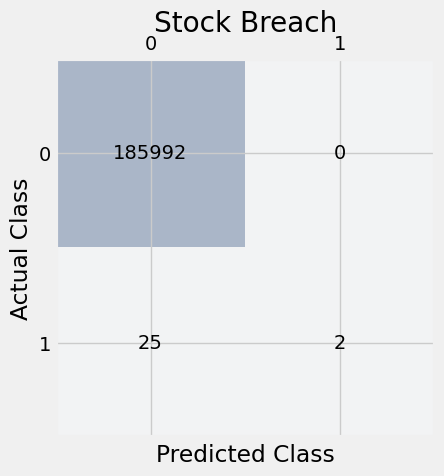

accuracy = 0.999865605126358
f1_score = 0.13793103448275862
precision = 1.0
recall = 0.07407407407407407
specificity = 1.0
opt_score = 0.2641452796296294



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39135 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21697 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 39135 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 21697 missing from current font.
  font.set_te

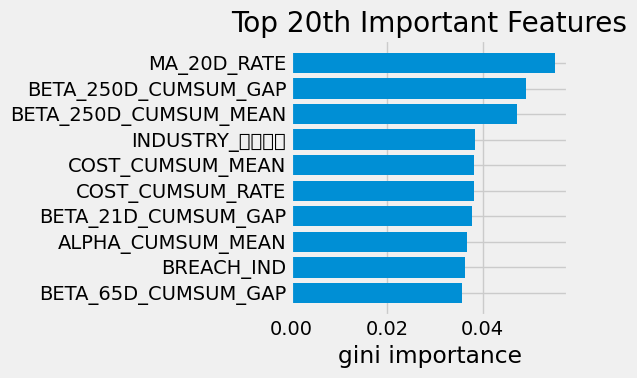

AUC: 0.866625


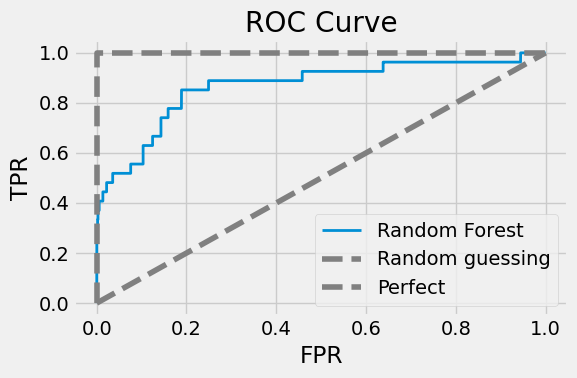

In [ ]:
plot_confusion_matrix(y_test,result)
plot_importance(rf,col_name)
plot_roc_curve(y_test, rf_probs)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# New random forest with only the two most important variables
rf_most_important = RandomForestClassifier(n_estimators= 100, random_state=42)

# Extract the two most important features
important_indices = [1,20] #1,2,9,10,11,12,13,15,20
train_important = x_train[:, important_indices]
test_important = x_test[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, y_train)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - y_test)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
np.save('my_array', x_test)

#Predict probability of customer

In [ ]:
import os
import joblib
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

#input customer info
cust_info = x_test[3:4,:]

#save model
joblib.dump(rf, "./random_forest.joblib")
loaded_rf = joblib.load("./random_forest.joblib")

#call the model
test_data_pred = loaded_rf.predict(x_test)
cust_pred = loaded_rf.predict(cust_info)

array([0.])

In [ ]:
#get probability from model
rf_probs = loaded_rf.predict_proba(x_test)
cust_prob = loaded_rf.predict_proba(cust_info)
x_1 = rf_probs[:,1].tolist()
cust_1 = cust_prob[:,1].tolist()

In [ ]:
# rescale the probability between [0,1]
mean = np.mean(x_1)
max = np.max(x_1)
min = np.min(x_1)

def minmax(x,mean,max,min):
  x_bar = abs((x-mean) / (max-min))*100
  if x_bar<0.5 and x_bar>0.3:
    safe = '安全，但須留意'
  elif x_bar<0.3 and x_bar>0.1:
    safe = '在安全範圍之內'
  elif x_bar<0.1 and x_bar>0:
    safe = '非常安全'
  else:
    safe = '有風險！請審慎評估'
  return np.round(x_bar,decimals=4), safe

prob_breach, safe = minmax(cust_1,mean,max,min)

print('您違約的機率是: {}％'.format(prob_breach[0]))
print('我們認為您這筆交易{}'.format(safe))
max

您違約的機率是: 0.1394％
我們認為您這筆交易在安全範圍之內


0.82

In [ ]:
from sklearn.tree import export_graphviz
import os

for tree_in_forest in rf.estimators_:
  export_graphviz(tree_in_forest,
                out_file='tree.dot',
                feature_names= X.columns,
                filled=True,
                rounded=True)
  

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Text(0.5, 1.0, 'Binary class Precision-Recall curve: AP=0.47')

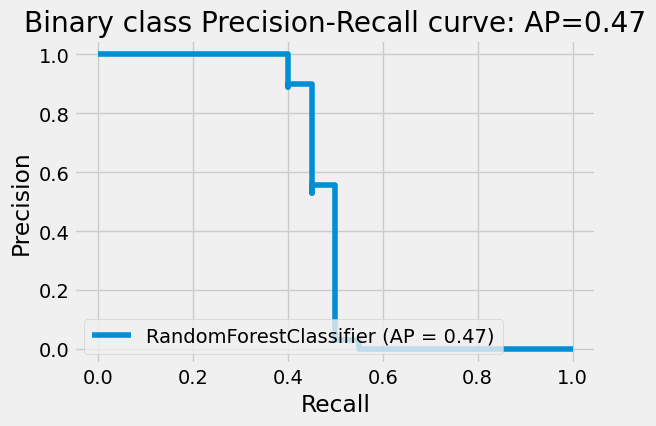

In [ ]:
#plot Precision-Recall curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
y_score =rf_classifier.predict_proba(x_test)[:, 1]
average_precision = average_precision_score(y_test, y_score)
disp = plot_precision_recall_curve(rf_classifier, x_test, y_test)
disp.ax_.set_title('Binary class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [ ]:
type(col_name)
col_name

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# New random forest with only the two most important variables
rf_most_important = RandomForestClassifier(n_estimators= 150)

# Extract the two most important features
important_indices = [77,8,26] #
train_important = x_train[:, important_indices]
test_important = x_test[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, y_train)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - y_test)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
plot_confusion_matrix(y_test,predictions)